In [359]:
import random
import math

import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.ticker as ticker

# Building the reference trace

## creating dataframes of object access and requests

In [373]:
def parse_post_object_access(post):
    objects = []
    for obj_s in post:
        objects.append({
            'timestamp': req_ts,
            'req_id': req_id, 
            'oid': obj_s['oid'], 
            'cache_name': obj_s['name'],
            'cache_hit': 0 if obj_s['miss'] == 'y' else 1
        })
    return objects

crr_fpath = join(wdir, 
                 f'/local0/serverless-social-network/results/zipf0.9/trace.zipf-0p9.60min.72p.24.crr.json')
with open(crr_fpath, 'r') as fd:
    ref_data = json.load(fd)
    ref_caches = []
    objects_access = []
    objects_meta = []
    for rd in ref_data:
        req_id = rd['request_id']
        req_ts = rd['timestamps']['main_start_ms']
        post_status = rd['object_access']
        for post in post_status:
            objects_access.extend(parse_post_object_access(post))
            
        objs_t = rd['objects']
        for obj in objs_t:
            objects_meta.append(obj)
    
    df_t = pd.DataFrame(objects_access)
    df_t = df_t.sort_values(by='timestamp').reset_index(drop=True) 
    
    df_obj = pd.DataFrame(objects_meta).groupby('oid').agg({'type': ['max', 'count'],
                                                           'size': 'max',
                                                           'author': 'max'})
    df_obj.columns = ['type', 'freq', 'size', 'author']
    df_obj['probablity'] = df_obj['freq']/df_obj['freq'].sum()
    df_obj_t = df_obj.reset_index(drop=False).sort_values(by='freq', ascending=False).reset_index(drop=True)

## Plot characteristics of the objects in the trace

# of social network requests: 72790
# of unique objects: 1065297
Total # of access: 2612397
Total size of unique objects: 107 GB
Total size of data access: 259 GB


,oid,type,freq,size,author,probablity
0,8529712069595998107,text,1358,881,52092,0.00052
1,1448527680661983843,PIC,1358,134773,52092,0.00052
2,9178416481701443371,PIC,1358,276470,52092,0.00052
3,3404978316259442134,PIC,1358,227835,52092,0.00052
4,4527297404702877604,PIC,1358,189142,52092,0.00052


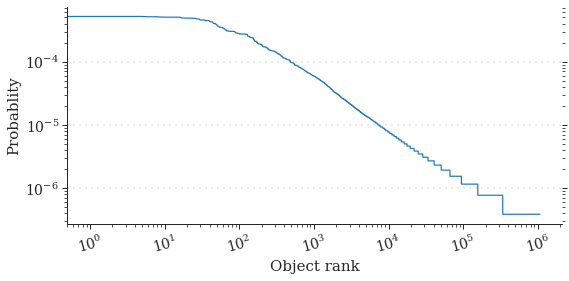

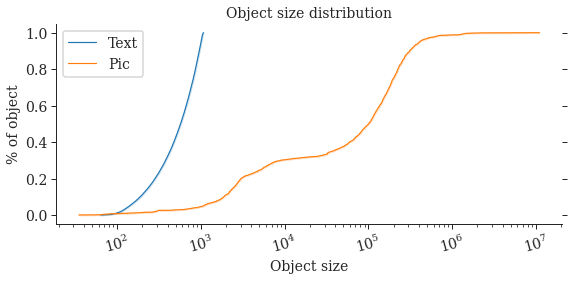

In [374]:
def plot_object_access_freq(df_obj):  
    sns.set_style("ticks")
        
    sns.set_context("paper", font_scale=1)
    sns.set_context(rc = {'patch.linewidth': 1.5, 'patch.color': 'black'})

    plt.rc('font', family='serif')

    fig, ax = plt.subplots(figsize=(8,4))
    sns.lineplot(data = df_obj_t, x = df_obj_t.index, y = 'probablity', ax=ax)
    sns.despine()
    
    ax.yaxis.grid(color='#99999910', linestyle=(0, (5, 10)), linewidth=0.4)
    ax.set_axisbelow(True)
    
    ax.set_xscale('log', base=10)
    ax.set_yscale('log', base=10)
    ax.set_xlabel('Object rank', fontsize=15)
    ax.set_ylabel('Probablity', fontsize=15)    

    ax.tick_params(axis='x', which='major', labelsize=14, rotation=15)
    ax.tick_params(axis='y', which='major', labelsize=14)
    ax.yaxis.set_ticks_position('both')
    
    plt.tight_layout()


def plot_object_size_distribution(df_obj):
    sns.set_style("ticks")
        
    sns.set_context("paper", font_scale=1)
    sns.set_context(rc = {'patch.linewidth': 1.5, 'patch.color': 'black'})

    plt.rc('font', family='serif')

    fig, ax = plt.subplots(figsize=(8,4))    
    N = len(df_obj[df_obj['type'] == 'text'])
    data = df_obj[df_obj['type'] == 'text']['size']
    x = np.sort(data)
    y = np.arange(N) / float(N)

    sns.lineplot(x='x', y='y', data=pd.DataFrame({'x': x, 'y': y}), label='Text')
    sns.despine()
    
    ax.yaxis.grid(color='#99999910', linestyle=(0, (5, 10)), linewidth=0.4)
    ax.set_axisbelow(True)
    
    # plotting
    ax.set_xlabel('Object size', fontsize=14)
    ax.set_ylabel('% of object', fontsize=14)
    ax.set_title('Object size distribution', fontsize=14)
    
    ax.tick_params(axis='x', which='major', labelsize=14, rotation=15)
    ax.tick_params(axis='y', which='major', labelsize=14)
    ax.yaxis.set_ticks_position('both')   
    
    N = len(df_obj[df_obj['type'] == 'PIC'])
    data = df_obj[df_obj['type'] == 'PIC']['size']
    x = np.sort(data)
    y = np.arange(N) / float(N)

    sns.lineplot(x='x', y='y', data=pd.DataFrame({'x': x, 'y': y}), label='Pic')
    sns.despine()
    
    ax.yaxis.grid(color='#99999910', linestyle=(0, (5, 10)), linewidth=0.4)
    ax.set_axisbelow(True)
    
    # plotting
    ax.set_xlabel('Object size', fontsize=14)
    ax.set_ylabel('% of object', fontsize=14)
    ax.set_title('Object size distribution', fontsize=14)
    
    ax.tick_params(axis='x', which='major', labelsize=14, rotation=15)
    ax.tick_params(axis='y', which='major', labelsize=14)
    ax.yaxis.set_ticks_position('both')   
    
    ax.set_xscale('log', base=10)
    #ax.set_yscale('log', base=10)
    
    
    ax.legend(fontsize=14)
    plt.tight_layout()
    
    
    pass


plot_object_access_characteristics(df_obj)
plot_object_size_distribution(df_obj)

print('# of social network requests:', df_t['req_id'].nunique())
print('# of unique objects:', len(df_obj)) 
print('Total # of access:', df_obj['freq'].sum())
print('Total size of unique objects:', f'{int(df_obj["size"].sum()) >>30} GB')
print('Total size of data access:', (df_obj['freq']*df_obj['size']).sum() >> 30, 'GB')

df_obj_t.head(5)

## Select x% percent of requests for processing 
### (request ids to be dropped from all of the traces)

In [395]:
drop_rate = 50
ndropped_req = df_t['req_id'].nunique()*drop_rate//100
df_req = df_t[['timestamp', 'req_id']].\
            groupby('req_id').agg('max').\
            reset_index(drop=False).sort_values('timestamp').\
            reset_index(drop=True)
dropped_req = list(df_req.iloc[0:ndropped_req]['req_id'].values)

print(f'# of requests to be dropped {len(dropped_req)}')

# of requests to be dropped 36395


# Process the requests (at cache-warm state) & compute memory waste and hit ratio

In [396]:
import json
import pandas
from os import listdir
from os.path import isfile, join
import pandas as pd 

wdir = '/local0/serverless-social-network/results/zipf0.9'
logfiles = [f for f in listdir(wdir) if isfile(join(wdir, f))]

trace_collection = {}
for fpath in logfiles:
    trace, n_workers, policy, _ = fpath.rsplit('.', 3)
    if n_workers not in trace_collection:
        trace_collection[n_workers] = {}
    if trace not in trace_collection[n_workers]:
        trace_collection[n_workers][trace] = []
    trace_collection[n_workers][trace].append(fpath)
    
print('Traces that are going to be parsed', json.dumps(trace_collection, indent=4))

Traces that are going to be parsed {
    "24": {
        "trace.zipf-0p9.60min.72p": [
            "trace.zipf-0p9.60min.72p.24.crr.json",
            "trace.zipf-0p9.60min.72p.24.random.json"
        ]
    },
    "2": {
        "trace.zipf-0p9.60min.72p": [
            "trace.zipf-0p9.60min.72p.2.crr.json",
            "trace.zipf-0p9.60min.72p.2.random.json"
        ]
    },
    "6": {
        "trace.zipf-0p9.60min.72p": [
            "trace.zipf-0p9.60min.72p.6.crr.json",
            "trace.zipf-0p9.60min.72p.6.random.json"
        ]
    },
    "12": {
        "trace.zipf-0p9.60min.72p": [
            "trace.zipf-0p9.60min.72p.12.random.json",
            "trace.zipf-0p9.60min.72p.12.crr.json"
        ]
    },
    "1": {
        "trace.zipf-0p9.60min.72p": [
            "trace.zipf-0p9.60min.72p.1.random.json",
            "trace.zipf-0p9.60min.72p.1.crr.json"
        ]
    }
}


trace.zipf-0p9.60min.72p.24.crr.json overall hit/miss ratio: 0.5841405730636203


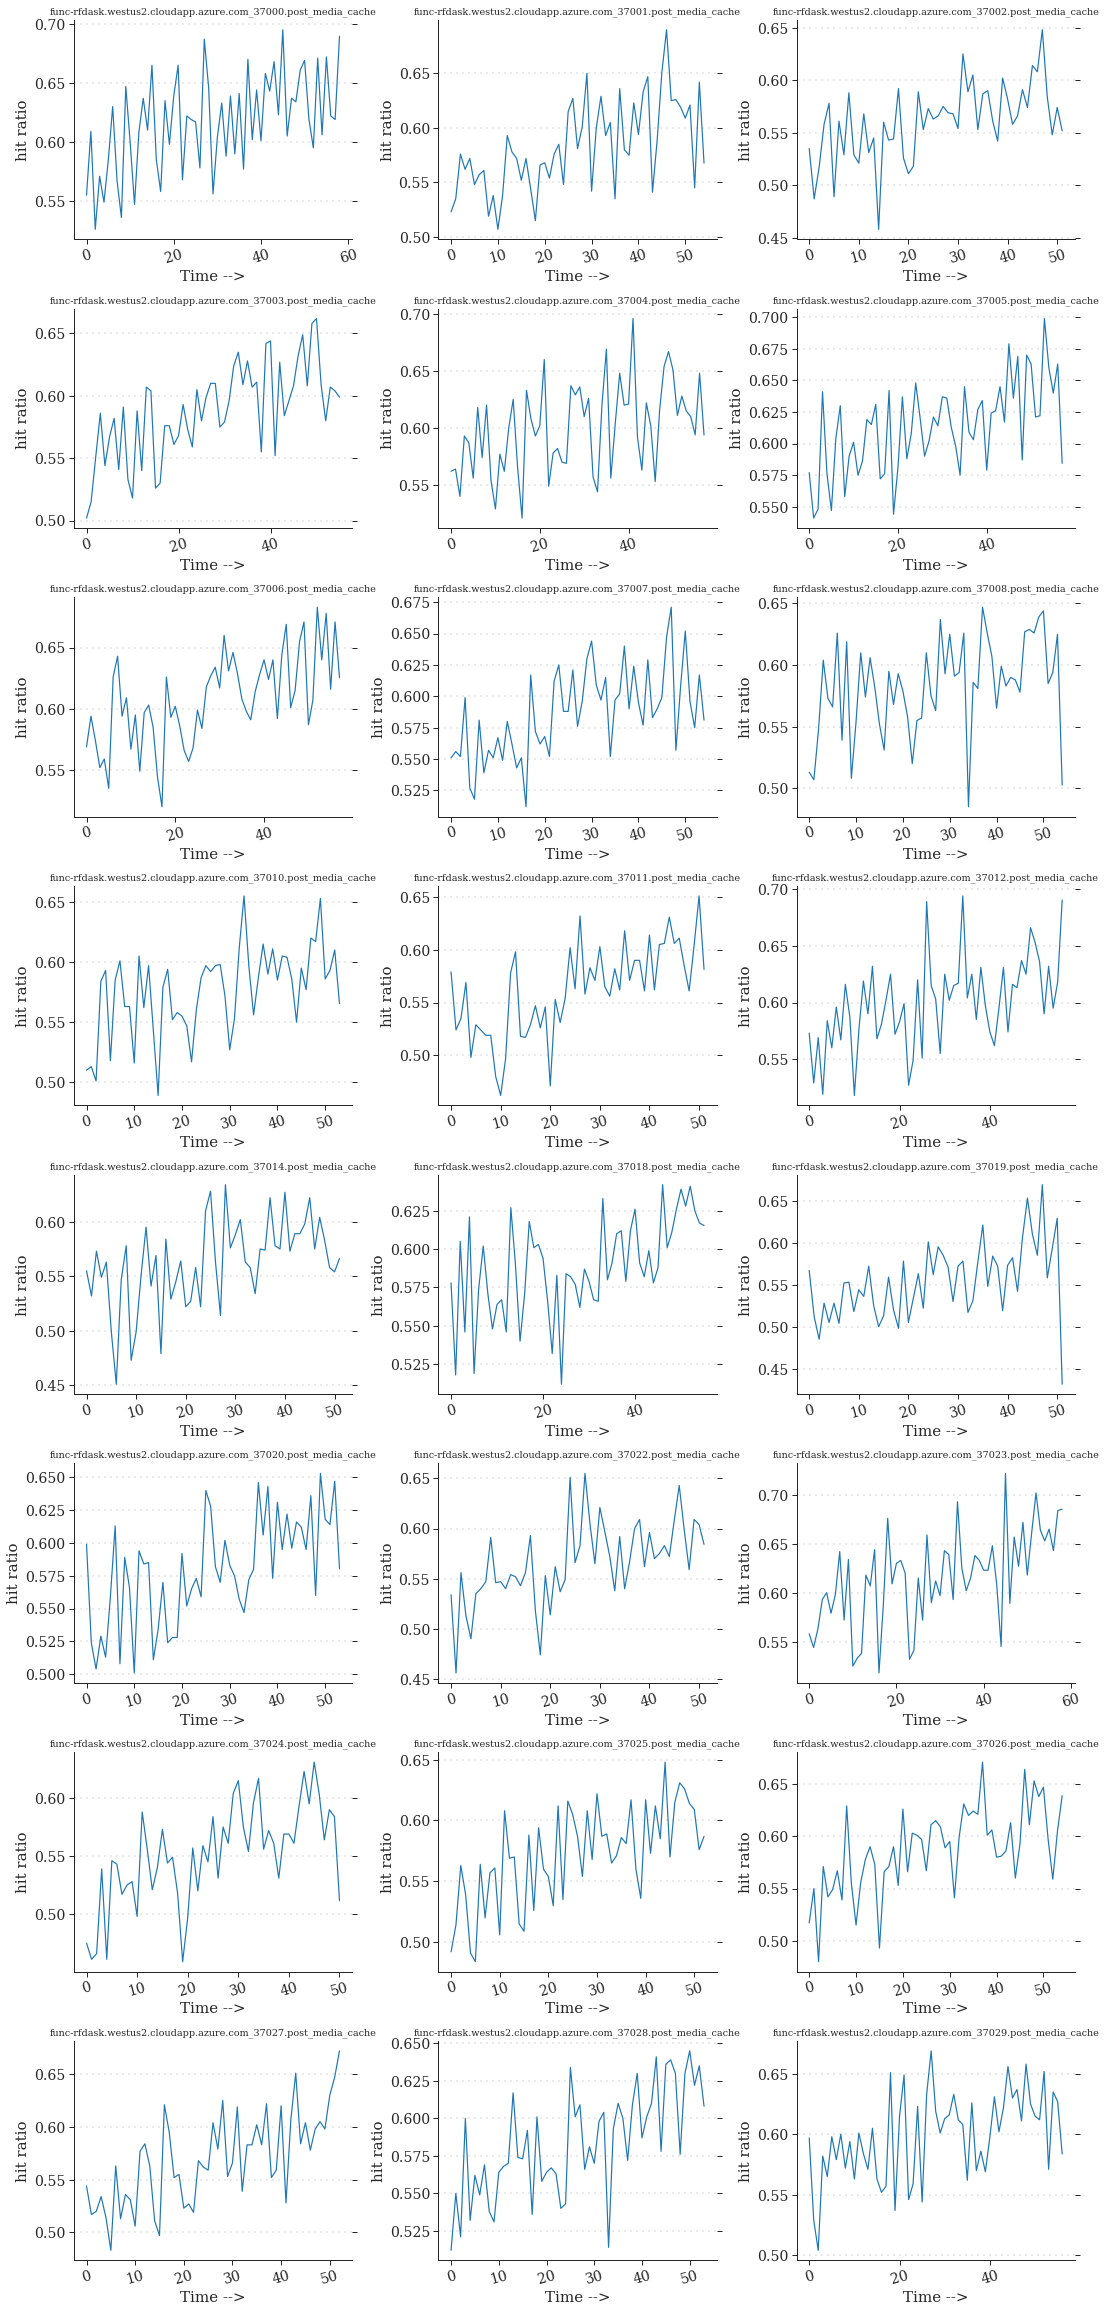

trace.zipf-0p9.60min.72p.24.random.json overall hit/miss ratio: 0.24942966361441357


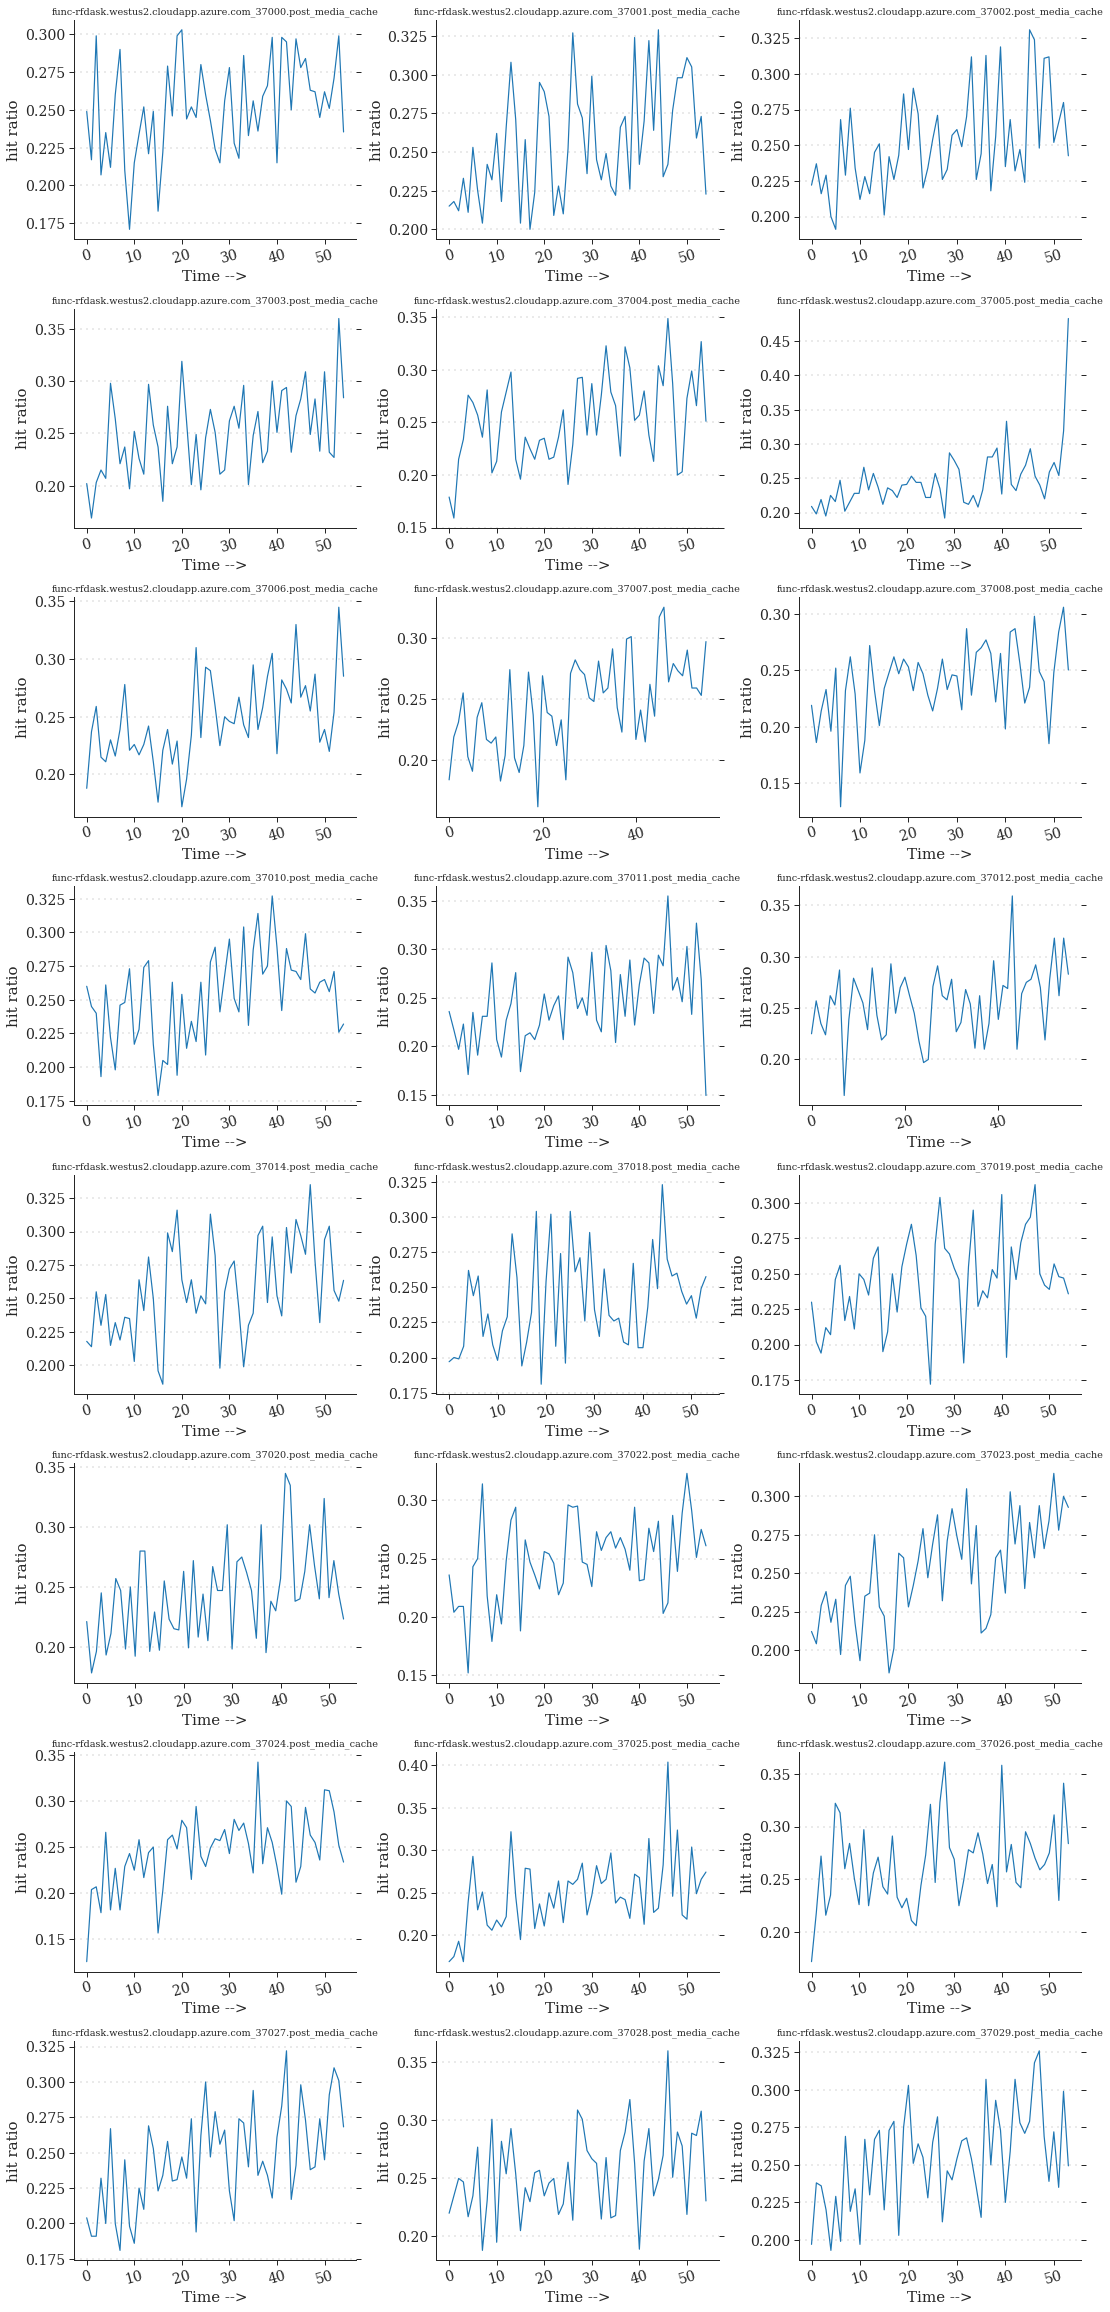

trace.zipf-0p9.60min.72p.2.crr.json overall hit/miss ratio: 0.5817396446897405


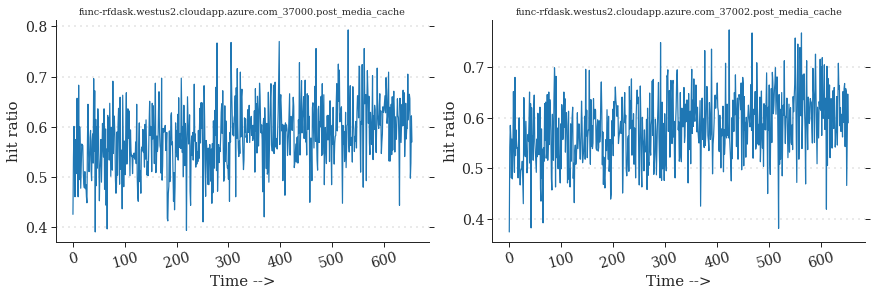

trace.zipf-0p9.60min.72p.2.random.json overall hit/miss ratio: 0.4940990424428266


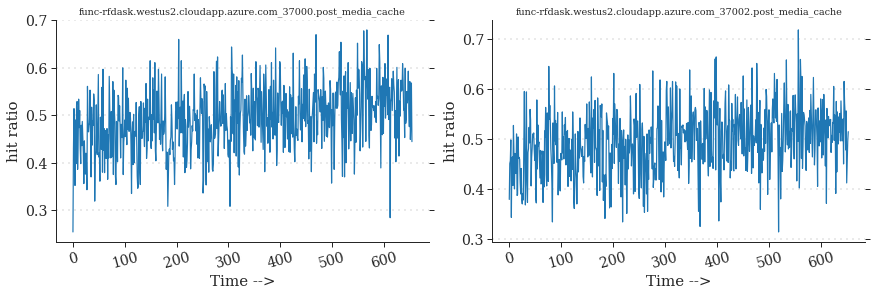

trace.zipf-0p9.60min.72p.6.crr.json overall hit/miss ratio: 0.5816606574663739


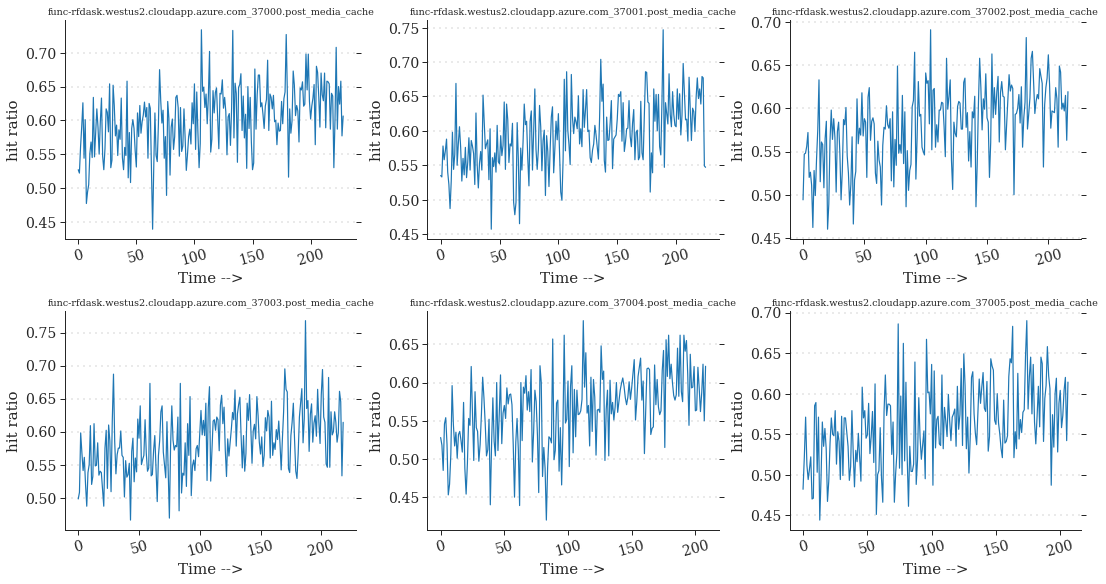

trace.zipf-0p9.60min.72p.6.random.json overall hit/miss ratio: 0.3740356514421238


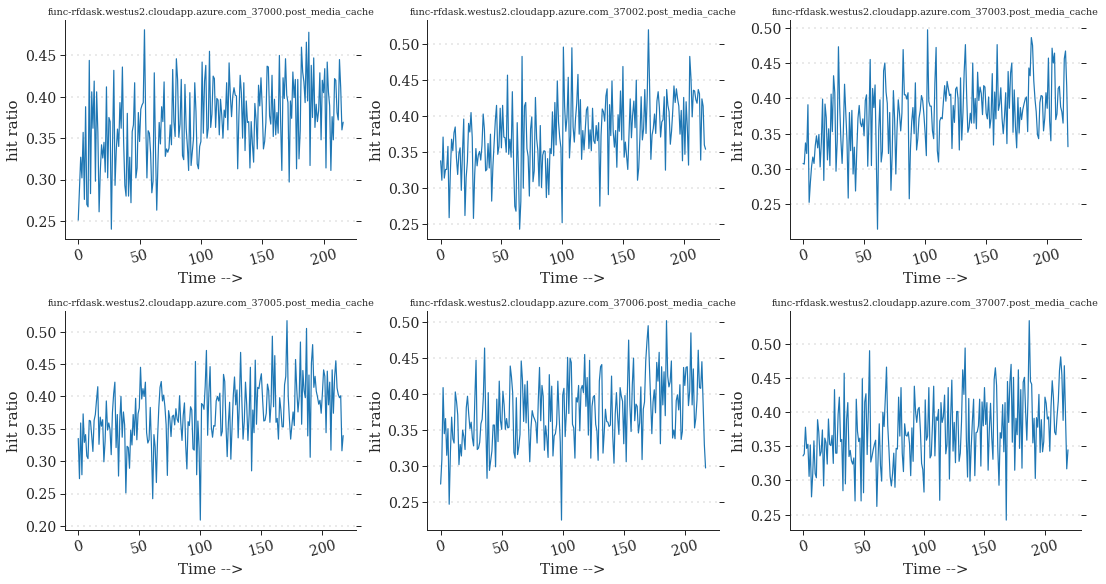

trace.zipf-0p9.60min.72p.12.random.json overall hit/miss ratio: 0.30794613217562344


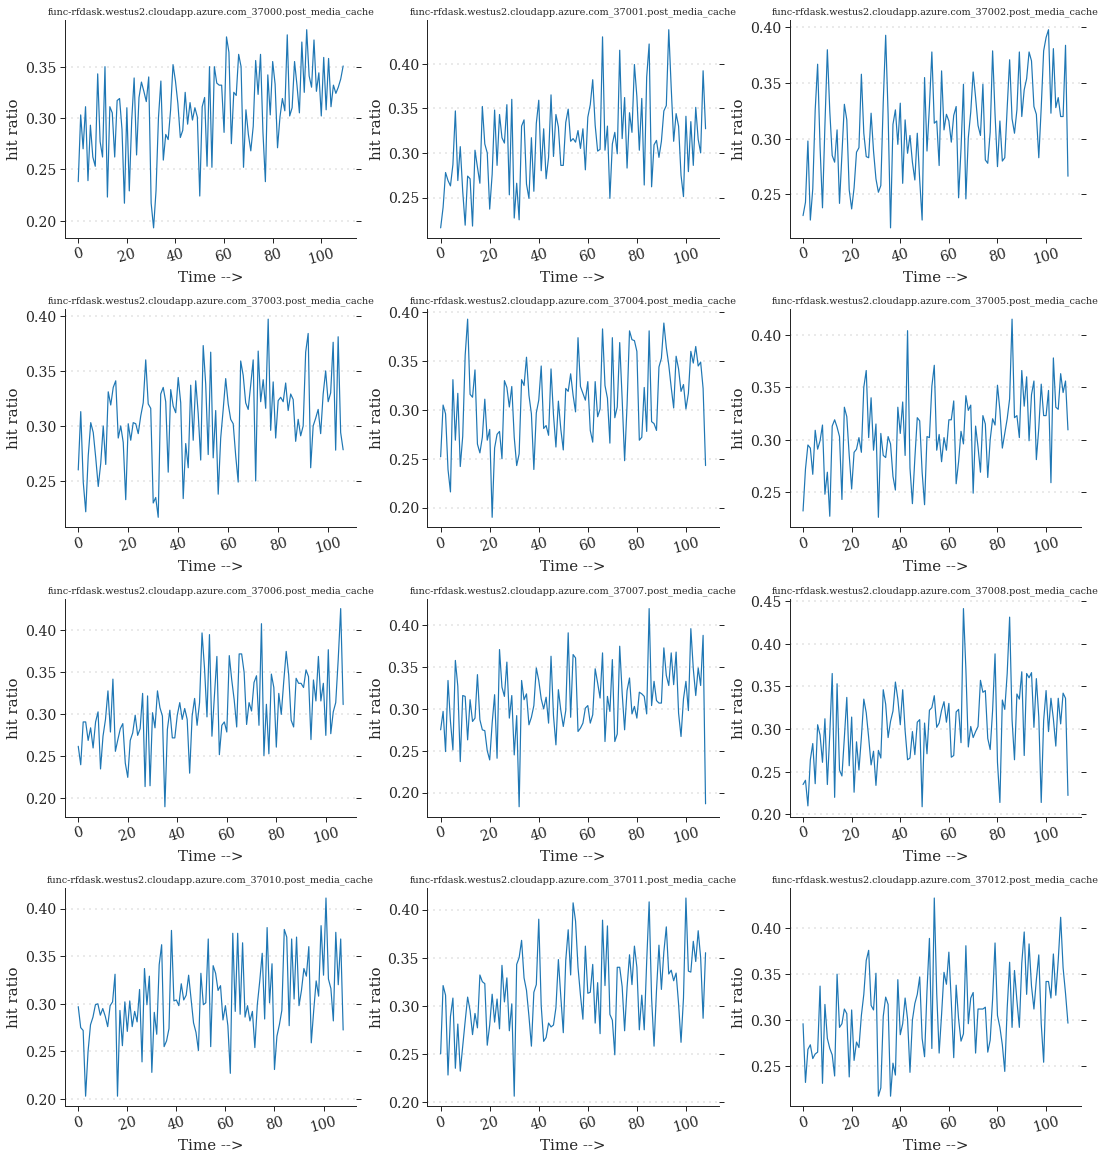

trace.zipf-0p9.60min.72p.12.crr.json overall hit/miss ratio: 0.5826007326007326


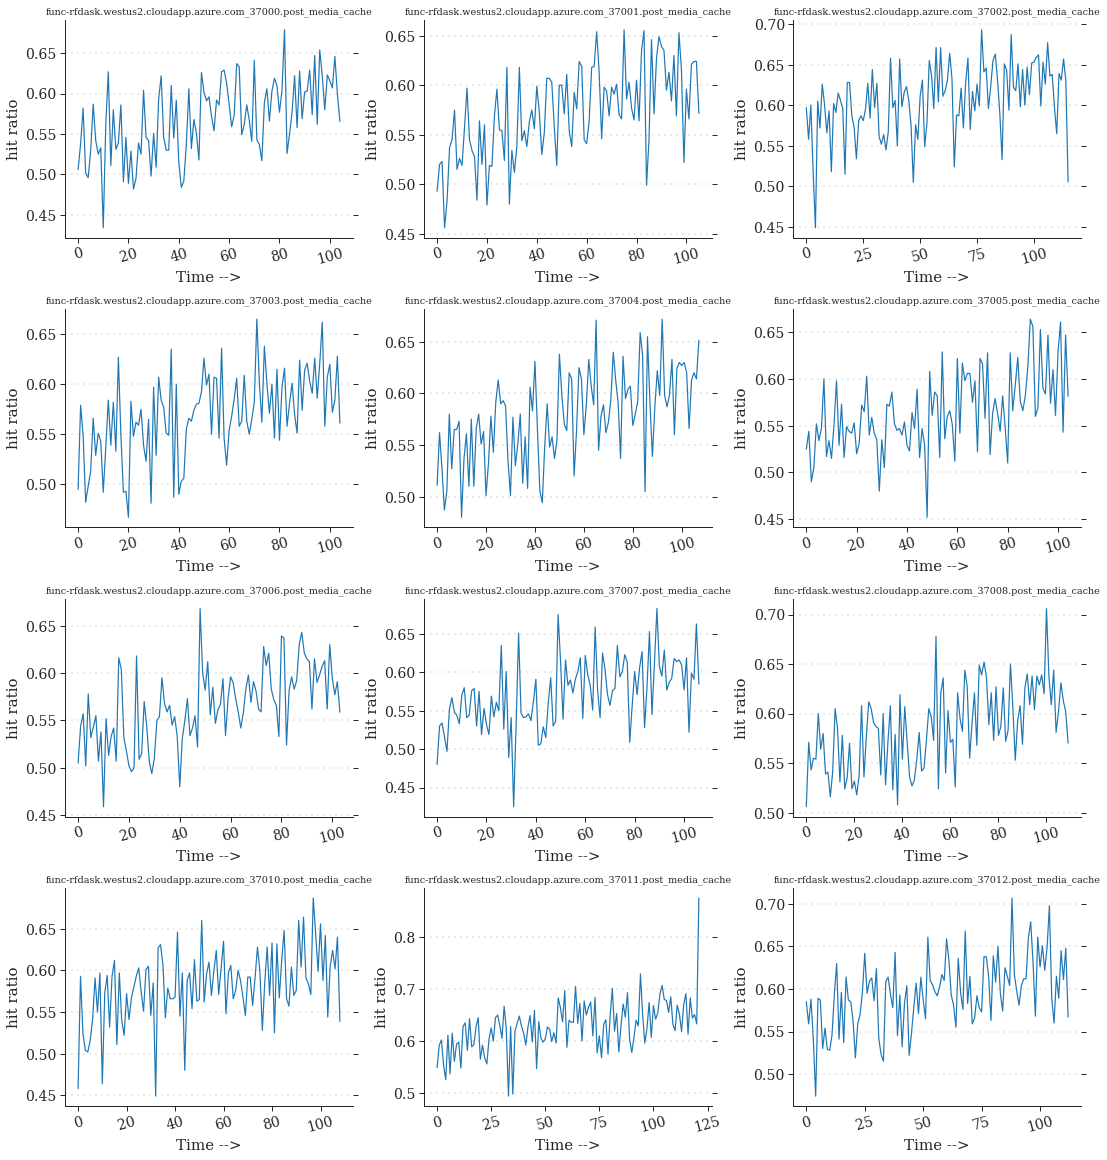

trace.zipf-0p9.60min.72p.1.random.json overall hit/miss ratio: 0.5816436167281944


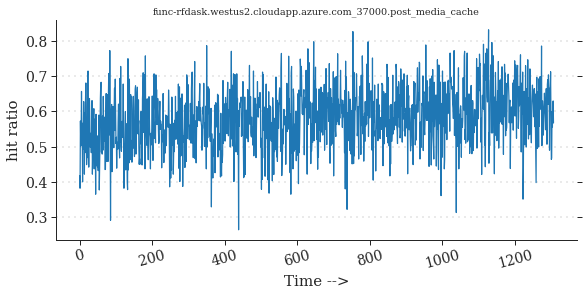

trace.zipf-0p9.60min.72p.1.crr.json overall hit/miss ratio: 0.5816436167281944


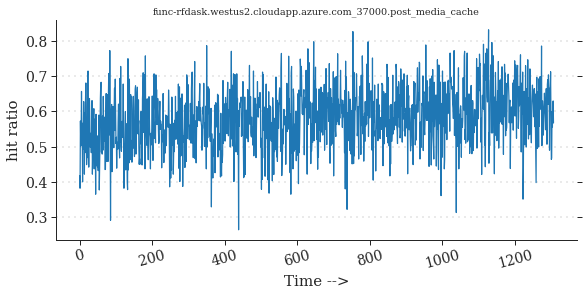

In [397]:
def build_df(fpath):
    with open(fpath, 'r') as fd:
        data = json.load(fd)
        caches = []
        objects_access = []
        for rd in data:
            req_id = rd['request_id']
            req_ts = rd['timestamps']['main_start_ms']
            post_status = rd['object_access']

            for post in post_status:
                for obj_s in post:
                    objects_access.append({
                        'timestamp': req_ts,
                        'req_id': req_id, 
                        'oid': obj_s['oid'], 
                        'cache_name': obj_s['name'],
                        'cache_hit': 0 if obj_s['miss'] == 'y' else 1
                    })
        df_t = pd.DataFrame(objects_access)
        df_t = df_t.sort_values(by='timestamp').reset_index(drop=True) 
        df = df_t[~df_t['req_id'].isin(dropped_req)].reset_index(drop = True)
        return df
    
def plot_hitratio_per_cache(df, n_workers):
    if n_workers in [6, 12, 24]:
        b = 3
        fig, axes = plt.subplots(ncols=3, nrows=n_workers//3, 
                                 constrained_layout=True, figsize=(15,4*n_workers//3))
    elif n_workers == 2:
        b = 2
        fig, axes = plt.subplots(ncols=2, nrows=1, constrained_layout=True,
                                figsize=(12,4))
    elif n_workers == 1:
        b = 1
        fig, axes = plt.subplots(ncols=1, nrows=1, constrained_layout=True,
                                figsize=(8,4))
    else: 
        print(isinstance(n_workers, str), n_workers) 
        return 
    
    sns.set_style("ticks")
    sns.set_context("paper", font_scale=1)
    sns.set_context(rc = {'patch.linewidth': 1.5, 'patch.color': 'black'})
    plt.rc('font', family='serif')

        
    dfcg = df.groupby('cache_name')
    index = 0
    for cache_name, g in dfcg:
        g = g.reset_index(drop=True).reset_index(drop=False)
        g['access_group'] = g['index']//1000
        df = g.groupby(['access_group']).agg({"cache_hit": ['sum', 'count']})
        df.columns = df.columns.get_level_values(1)
        df['hitratio'] = df['sum']/df['count']
        
        if b == 3:
            ax = axes[index//b, index%b]
        elif b == 2:
            ax = axes[index%2]
        elif b == 1:
            ax = axes
            
        sns.lineplot(x='access_group', y='hitratio', data=df, ax=ax)
        sns.despine()
    
        ax.yaxis.grid(color='#99999910', linestyle=(0, (5, 10)), linewidth=0.4)
        ax.set_axisbelow(True)

        ax.set_xlabel('Time -->', fontsize=15)
        ax.set_ylabel('hit ratio', fontsize=15)    

        ax.tick_params(axis='x', which='major', labelsize=14, rotation=15)
        ax.tick_params(axis='y', which='major', labelsize=14)
        ax.yaxis.set_ticks_position('both')
        
        ax.set_title(f'{cache_name}')
        index += 1
    plt.show()
    return

hit_ratio_stats = []
for n_workers in trace_collection:
    for tname in trace_collection[n_workers]:
        for exec_name in trace_collection[n_workers][tname]:
            fpath = os.path.join(wdir, exec_name)
            df = build_df(fpath)
            
            policy = exec_name.rsplit('.', 3)[2]
            hit_ratio = len(df[df['cache_hit'] == 1])/len(df)
            hit_ratio_stats.append({'workers': int(n_workers), 
                                   'policy': policy,
                                   'hit_ratio': hit_ratio})
            print(f'{exec_name} overall hit/miss ratio:', hit_ratio)
            plot_hitratio_per_cache(df, int(n_workers))
            
            #break
        #break
    #break

# Plot end-to-end

AttributeError: 'AxesSubplot' object has no attribute 'set_'

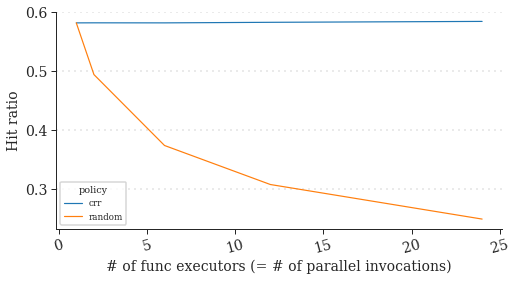

In [398]:
sns.set_style("ticks")
        
sns.set_context("paper", font_scale=1)
sns.set_context(rc = {'patch.linewidth': 1.5, 'patch.color': 'black'})

plt.rc('font', family='serif')

fig, ax = plt.subplots(figsize=(8,4))    

max_hit_ratio = 1 - df['oid'].nunique()/len(df)
hr_df = pd.DataFrame(data = hit_ratio_stats)
sns.lineplot(x='workers', y='hit_ratio', hue='policy', data=hr_df)

sns.despine()

ax.yaxis.grid(color='#99999910', linestyle=(0, (5, 10)), linewidth=0.4)
ax.set_axisbelow(True)

# plotting
ax.set_xlabel('# of func executors (= # of parallel invocations)', fontsize=14)
ax.set_ylabel('Hit ratio', fontsize=14)

ax.tick_params(axis='x', which='major', labelsize=14, rotation=15)
ax.tick_params(axis='y', which='major', labelsize=14)
ax.set_
ax.yaxis.set_ticks_position('both')   


#ax.hlines(y = max_hit_ratio, xmin=-0.5, xmax=5, dashes = '--')
ax.legend(['LA', 'Oblivious'],fontsize=12, frameon=False, prop={"size":14})
plt.tight_layout()
fig.savefig(os.path.join('../plots', f'hitratio.socialnetwork.png'), 
                format='png', dpi=200)
fig.savefig(os.path.join('../plots', f'hitratio.socialnetwork.pdf'), 
                format='pdf', dpi=200)

plt.show()
hr_df #max_hit_ratio

# Memory waste per policy

/local0/serverless-social-network/results/trace.zipf-0p9.60min.72p.24.crr.csv


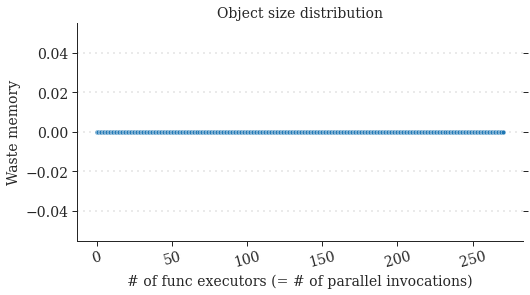

/local0/serverless-social-network/results/trace.zipf-0p9.60min.72p.24.random.csv


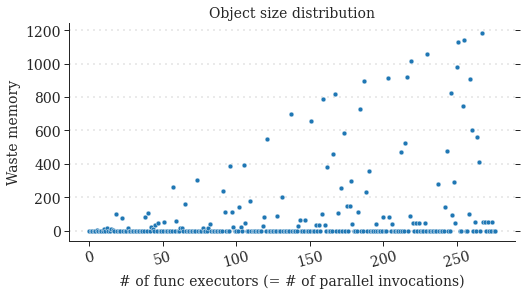

/local0/serverless-social-network/results/trace.zipf-0p9.60min.72p.2.crr.csv


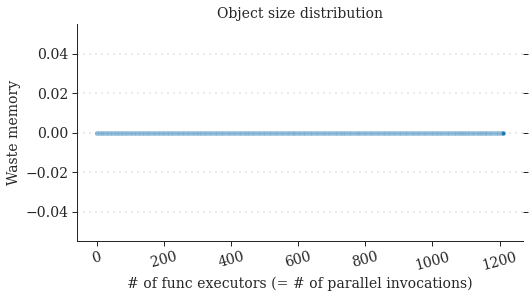

/local0/serverless-social-network/results/trace.zipf-0p9.60min.72p.2.random.csv


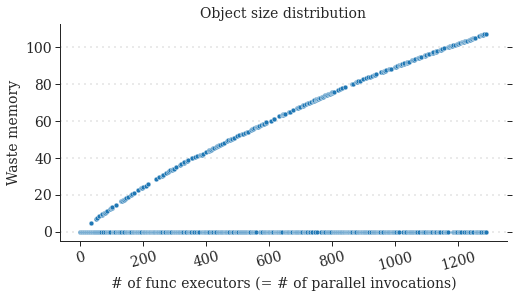

/local0/serverless-social-network/results/trace.zipf-0p9.60min.72p.6.crr.csv


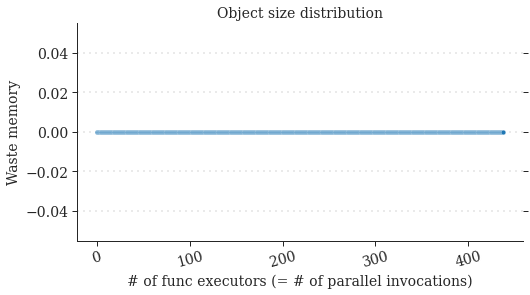

/local0/serverless-social-network/results/trace.zipf-0p9.60min.72p.6.random.csv


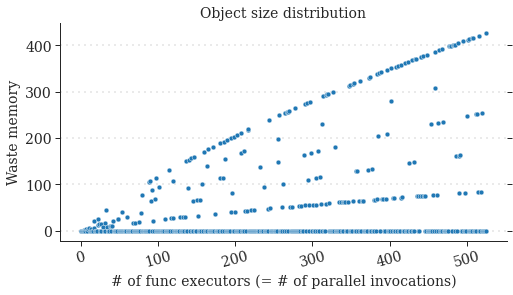

/local0/serverless-social-network/results/trace.zipf-0p9.60min.72p.12.random.csv


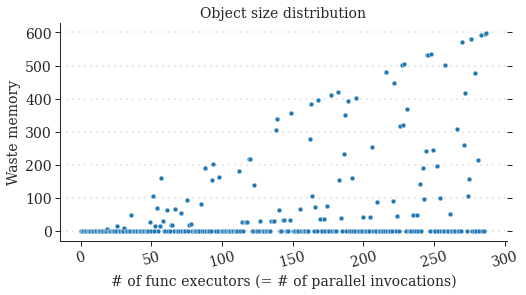

/local0/serverless-social-network/results/trace.zipf-0p9.60min.72p.12.crr.csv


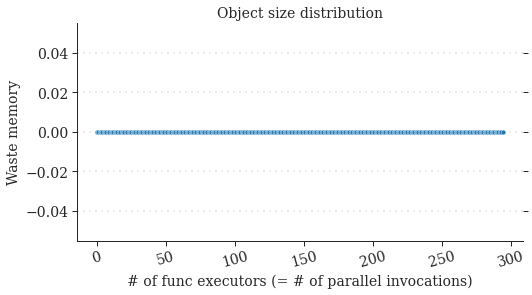

/local0/serverless-social-network/results/trace.zipf-0p9.60min.72p.1.random.csv


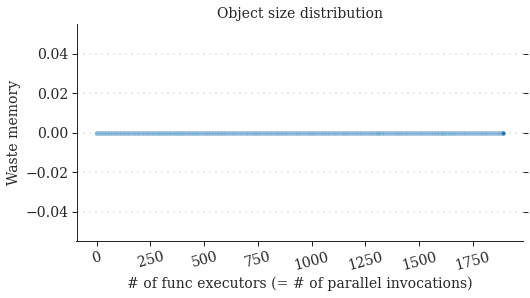

/local0/serverless-social-network/results/trace.zipf-0p9.60min.72p.1.crr.csv


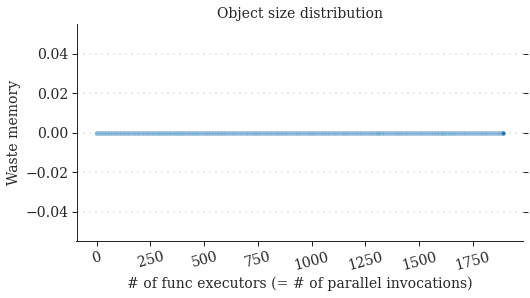

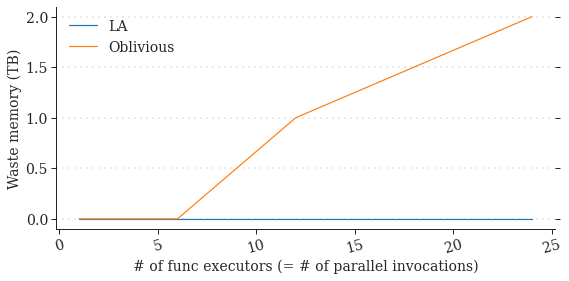

,n_workers,random,crr
0,24,2,0
1,2,0,0
2,6,0,0
3,12,1,0
4,1,0,0


In [394]:
def plot_memusage_per_cache(df):
    df['ts_min'] = df['relative']//10000
    df_mem = df.groupby('ts_min').agg({'mem_sz': 'max'}).reset_index()
    df_mem['mem_g'] = df['mem_sz']/(1<<30)
    sns.set_style("ticks")
        
    sns.set_context("paper", font_scale=1)
    sns.set_context(rc = {'patch.linewidth': 1.5, 'patch.color': 'black'})

    plt.rc('font', family='serif')

    fig, ax = plt.subplots(figsize=(8,4))    
    sns.scatterplot(x='ts_min', y='mem_g', data=df_mem, ax=ax)    
    sns.despine()

    ax.yaxis.grid(color='#99999910', linestyle=(0, (5, 10)), linewidth=0.4)
    ax.set_axisbelow(True)

    # plotting
    ax.set_xlabel('# of func executors (= # of parallel invocations)', fontsize=14)
    ax.set_ylabel('Waste memory', fontsize=14)
    ax.set_title('Object size distribution', fontsize=14)

    ax.tick_params(axis='x', which='major', labelsize=14, rotation=15)
    ax.tick_params(axis='y', which='major', labelsize=14)
    ax.yaxis.set_ticks_position('both')   
    plt.show()
    return
    
wdir = '/local0/serverless-social-network/results'
        
total_mem_waste = []
for n_workers in trace_collection:
    for tname in trace_collection[n_workers]:
        for exec_name in trace_collection[n_workers][tname]:
            fpath = os.path.join(wdir, exec_name.replace('json', 'csv'))
            print(fpath)
            df = pd.read_csv(fpath)
            mem_waste = df['mem_sz'].max()
            if 'crr' in exec_name:
                crr_waste = mem_waste
            if 'random' in exec_name:
                random_waste = mem_waste
            plot_memusage_per_cache(df)
    total_mem_waste.append({'n_workers': int(n_workers),
                          'random': random_waste>>40,
                           'crr': crr_waste})
            #
            #break
            
mem_df = pd.DataFrame(data = total_mem_waste)

sns.set_style("ticks")
        
sns.set_context("paper", font_scale=1)
sns.set_context(rc = {'patch.linewidth': 1.5, 'patch.color': 'black'})

plt.rc('font', family='serif')

fig, ax = plt.subplots(figsize=(8,4))    
sns.lineplot(x='n_workers', y='crr', data=mem_df, label = 'LA')
sns.lineplot(x='n_workers', y='random', data=mem_df, label = 'Oblivious')
sns.despine()

ax.yaxis.grid(color='#99999910', linestyle=(0, (5, 10)), linewidth=0.4)
ax.set_axisbelow(True)

ax.set_xlabel('# of func executors (= # of parallel invocations)', fontsize=14)
ax.set_ylabel('Waste memory (TB)', fontsize=14)

ax.tick_params(axis='x', which='major', labelsize=14, rotation=15)
ax.tick_params(axis='y', which='major', labelsize=14)
ax.yaxis.set_ticks_position('both')  

ax.legend(['LA', 'Oblivious'],fontsize=12, frameon=False, prop={"size":14})
plt.tight_layout()
fig.savefig(os.path.join('../plots', f'wastemem.socialnetwork.png'), 
                format='png', dpi=200)
fig.savefig(os.path.join('../plots', f'wastemem.socialnetwork.pdf'), 
                format='pdf', dpi=200)

plt.show()


mem_df

In [307]:
fpath = join(wdir, 
                 f'/local0/serverless-social-network/results/zipf0.9/trace.zipf-0p9.60min.72p.2.random.json')
with open(fpath) as fd:
    data = json.load(fd)
    dd = []
    for rd in data:
        cache_stats = rd['cache_status']
        
        for cs in cache_stats:
            dd.append({'ts': cs['timestamp'], 'nacess': cs['n_access'], 'name': cs['name']})
        

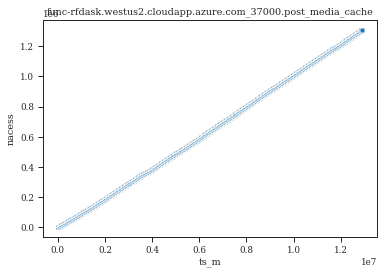

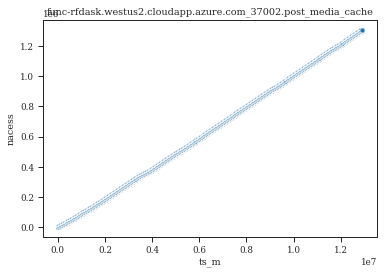

In [309]:
ddf = pd.DataFrame(data=dd)

for index, ddfi in ddf.groupby('name'):
    ddfi['ts_m'] = ddfi['ts'] -  ddfi['ts'].min()
    ax = sns.scatterplot(x='ts_m', y='nacess', data=ddfi)
    ax.set_title(index)
    plt.show()

In [298]:
ddfi.sort_values(by='nacess', ascending=False)

,ts,nacess,name
451229,1633517887911,398989,func-rfdask.westus2.cloudapp.azure.com_37001.p...
451228,1633517874469,398978,func-rfdask.westus2.cloudapp.azure.com_37001.p...
451219,1633517865454,398973,func-rfdask.westus2.cloudapp.azure.com_37001.p...
451218,1633517796455,398969,func-rfdask.westus2.cloudapp.azure.com_37001.p...
451217,1633517793859,398961,func-rfdask.westus2.cloudapp.azure.com_37001.p...
...,...,...,...
451238,1633518162556,5,func-rfdask.westus2.cloudapp.azure.com_37001.p...
20,1633508047849,5,func-rfdask.westus2.cloudapp.azure.com_37001.p...
451236,1633518162402,4,func-rfdask.westus2.cloudapp.azure.com_37001.p...
671942,1633522757173,3,func-rfdask.westus2.cloudapp.azure.com_37001.p...


In [301]:
6472029.726387 - 6467562.770119

4466.956267999485

In [ ]:

obj_in_cache = {}
mem_usage = []
for index, rd in enumerate(data):    
    req_id = rd['request_id']
    req_ts = rd['timestamps']['main_start_ms']
    post_status = rd['object_access']

    for post in post_status:
        for obj_s in post:
            oid = obj_s['oid']
            if oid not in obj_in_cache:
                obj_in_cache[oid] = {'caches': set()}
            obj_in_cache[oid]['caches'].add(obj_s['name'])
            
            for e_oid in obj_s['evicted']:
                if e_oid not in obj_in_cache:
                    print(f'why was {e_oid} not found?')
                    continue
                obj_in_cache[e_oid]['caches'].discard(obj_s['name'])
                
    post_mem = 0
    for p_oid in obj_in_cache:
        if p_oid not in objects:
            print('This is very odd! I think this happend becauseo of lost requests')
        obj_size = objects[p_oid] if p_oid in objects else 1
        # just substract it from 1 to keep the extra copy 
        post_mem += (len(obj_in_cache[oid]['caches']) - 1)*obj_size
    mem_usage.append({'timestamp': req_ts, 
                     'mem_sz': post_mem})

    if index%100 == 99:
        print(f'{index} out of {len(data)}')
        #print(obj_in_cache)
        #break
        
    #break

,ts_min,mem_sz
0,0,10480574324
1,1,18506050908
2,2,40791410368
3,3,62588934094
4,4,59011524624
5,5,78671672004
6,6,83910176852
7,7,122206226940
8,8,125584795880
9,9,149935531200


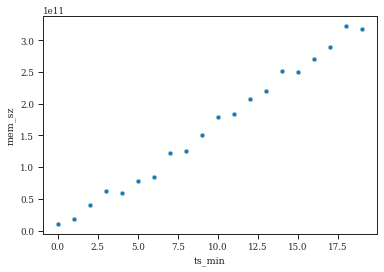

In [275]:
df_mem = pd.DataFrame(mem_usage)
df_mem['relative'] = df_mem['timestamp'] - df_mem['timestamp'].min()
df_mem['ts_min'] = df_mem['relative']//10000
#df_mem = df_mem.sort_values(by='timestamp').reset_index(drop=True)

df_mem_t = df_mem.groupby('ts_min').agg({'mem_sz': 'max'}).reset_index()

sns.scatterplot(x='ts_min', y='mem_sz', data=df_mem_t)

df_mem_t